In [2]:
# Step 0. Load libraries and custom modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re
from dateutil.parser import parse
from datetime import datetime
from tqdm import tqdm
# ------------  PREPROCESING -------------
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from textstat import flesch_kincaid_grade
#-------------- TRANSFORMERS --------------
import transformers
from transformers.pipelines import PIPELINE_REGISTRY
from transformers import pipeline
import evaluate
from evaluate import load
from transformers import Conversation
transformers.logging.set_verbosity_error()

/home/arnaldochm/Documents/BootCamp_DataScience/Final_Project/final_project_nlp/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-08 01:20:29.664180: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-08 01:20:29.665997: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 01:20:29.705656: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-08 01:20:29.706553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimize

In [3]:
df_reduced = pd.read_csv('../data/processed/df_reduced.csv')
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15738 entries, 0 to 15737
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15738 non-null  int64 
 1   num_row     15738 non-null  int64 
 2   text        15738 non-null  object
dtypes: int64(2), object(1)
memory usage: 369.0+ KB


In [4]:
df_reduced = df_reduced.drop(['Unnamed: 0'], axis= 1)

In [5]:
df_reduced.sample(10)

,num_row,text
9301,9301,"Naomi Alderman's ""Disobedience"" is the story o..."
8917,8917,I've long been familiar with Brite's horror ge...
8784,8784,I downloaded this for my wife - as she said sh...
6503,6503,I am a Woods fan and enjoy all his books. This...
4075,4075,Hilarious!Garden Lunacy: A Growing ConcernThis...
14514,14514,"Usually with books on writing, I only find som..."
12487,12487,Interesting read. Brutally honest. I found the...
15252,15252,"Toppamono is a speedy, exciting and somewhat b..."
9620,9620,I've read this book in Russian language. In my...
9147,9147,"I really wanted to like this one, but the prem..."


In [6]:
# def clean_stopwords(text: str,stop_dict: dict)->str:
#     if text is not None:
#         words = text.split()
#         words_clean = []
#         for word in words:
#             if word not in stop_dict:
#                 words_clean.append(word)
#         result = ' '.join(words_clean)
#     else:
#         result = None
#     return result

In [7]:
# 3.10 Text To Lower
df_reduced['text_clean'] = df_reduced['text'].str.lower()
# 3.12 Extract special characters and numbers
df_reduced['text_clean'] = df_reduced['text_clean'].str.replace(r'[^a-z]', ' ', regex=True)
# 3.13 Extract numbers
# df_reduced['text_clean'] = df_reduced['text_clean'].str.replace(r'[\d]+', '', regex=True)
# 3.14 #Change multiple white spaces to a single white space
df_reduced['text_clean'] = df_reduced['text_clean'].str.replace(r'\s+',' ',regex=True)

In [8]:
# 3.15 Lemmatize Text and removing Stopwords

download("wordnet")
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/arnaldochm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
download("stopwords")
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/arnaldochm/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
def lemmatize_text(words, lemmatizer = lemmatizer):
    words = words.split(' ')
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 2] #Keep Words with more than 3 letters
    return ' '.join(tokens)

In [11]:
df_reduced["text_clean"] = df_reduced["text_clean"].apply(lambda x: lemmatize_text(x))
df_reduced["text_clean"].sample(10)

4164     hate book maybe biased instructor find clear p...
14668    already studied previous edition bought second...
11047    compare novel vinci code doe great disservice ...
4150     emma favorite house great text free kindle edi...
14949    read ethnic america back second master degree ...
4617     best series book ever read finish one wait get...
6955     ann perry book young people three different ba...
15286    book decent shape knew buying new one got expe...
12176    rating textbook virtually impossible please ta...
4055     could easily write many negative thing novel s...
Name: text_clean, dtype: object

In [12]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/arnaldochm/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
def calculate_complexity(review):
    return flesch_kincaid_grade(review)

In [14]:
df_reduced['text_complexity'] = df_reduced['text'].apply(calculate_complexity)
df_reduced.sample(10)

,num_row,text,text_clean,text_complexity
14517,14517,Jules Verne captures the imagination with a tr...,jules verne capture imagination tremendous acc...,5.4
3429,3429,An honest and refreshing look at what so many ...,honest refreshing look many fall prey masking ...,9.4
3026,3026,I was very excited to read this book after rea...,excited read book reading great review however...,7.2
12740,12740,"Excellent usage of vocabulary, but the plot ca...",excellent usage vocabulary plot rather difficu...,7.2
7809,7809,This is a superbly written book (and for the r...,superbly written book record narrated author a...,8.2
241,241,"This is a book worth reading, especially for t...",book worth reading especially still believe da...,12.0
7395,7395,I have used this book to assist my church mini...,used book assist church ministry divorce care ...,6.0
4054,4054,I read this book some time ago for a book club...,read book time ago book club thought total sno...,4.0
328,328,"Arthur Dent, Ford Perfect, and a few of their-...",arthur dent ford perfect lack better word frie...,8.7
14604,14604,This book kept my attention from beginning to ...,book kept attention beginning end sometimes si...,6.5


In [15]:
df_reduced = df_reduced.drop(['text'],axis=1)

In [16]:
# 3.14 See the results
df_reduced.head(10)

,num_row,text_clean,text_complexity
0,0,purchased book neice cruised week loved story ...,4.5
1,1,really enjoyed book several front author terri...,9.0
2,2,interesting informative spot good book read wa...,6.0
3,3,must learn past history better appreciate toda...,6.7
4,4,began book high hope cover blurb sounded inter...,10.7
5,5,gary demar succeeded writing finest short actu...,7.6
6,6,first miss julia book found quite delightful b...,9.2
7,7,enjoying read assuming writes like think long ...,3.7
8,8,book simply great start reading able put page ...,5.8
9,9,hobbit written bit differently lord ring time ...,7.9


In [17]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/arnaldochm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [18]:
vaderSentimentAnalyzer = SentimentIntensityAnalyzer()

In [19]:
df_reduced.iloc[67]['text_clean']

'goethe expressed fundamental truth nothing much philosophy footnote plato plotinus year later plato eliminated platonic dabbling politics quietly separated greek mysticism emerging fundamentalism christianity became somewhat bemusedly cult figure right brian hines deal subject hugely sympathatic way hope future something doe change time plato century close one timeless truth time well according plotinus father robin'

In [20]:
vaderSentimentAnalyzer.polarity_scores(df_reduced.iloc[67]['text_clean'])

{'neg': 0.0, 'neu': 0.838, 'pos': 0.162, 'compound': 0.8344}

In [21]:
df_reduced['scores']=df_reduced['text_clean'].apply(lambda body: vaderSentimentAnalyzer.polarity_scores(str(body)))
df_reduced.head()

,num_row,text_clean,text_complexity,scores
0,0,purchased book neice cruised week loved story ...,4.5,"{'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'comp..."
1,1,really enjoyed book several front author terri...,9.0,"{'neg': 0.12, 'neu': 0.58, 'pos': 0.3, 'compou..."
2,2,interesting informative spot good book read wa...,6.0,"{'neg': 0.0, 'neu': 0.537, 'pos': 0.463, 'comp..."
3,3,must learn past history better appreciate toda...,6.7,"{'neg': 0.091, 'neu': 0.566, 'pos': 0.343, 'co..."
4,4,began book high hope cover blurb sounded inter...,10.7,"{'neg': 0.086, 'neu': 0.667, 'pos': 0.247, 'co..."


In [22]:
df_reduced['compound_sentiment']=df_reduced['scores'].apply(lambda score_dict:score_dict['compound'])
df_reduced.head()

,num_row,text_clean,text_complexity,scores,compound_sentiment
0,0,purchased book neice cruised week loved story ...,4.5,"{'neg': 0.0, 'neu': 0.664, 'pos': 0.336, 'comp...",0.9623
1,1,really enjoyed book several front author terri...,9.0,"{'neg': 0.12, 'neu': 0.58, 'pos': 0.3, 'compou...",0.9895
2,2,interesting informative spot good book read wa...,6.0,"{'neg': 0.0, 'neu': 0.537, 'pos': 0.463, 'comp...",0.7096
3,3,must learn past history better appreciate toda...,6.7,"{'neg': 0.091, 'neu': 0.566, 'pos': 0.343, 'co...",0.9595
4,4,began book high hope cover blurb sounded inter...,10.7,"{'neg': 0.086, 'neu': 0.667, 'pos': 0.247, 'co...",0.9936


In [23]:
df_reduced = df_reduced.drop(['scores'], axis=1)
df_reduced.sample(10)

,num_row,text_clean,text_complexity,compound_sentiment
3589,3589,book finally cut mystery surrounding god plan ...,10.3,-0.5574
4405,4405,book okay disappointment reading marianna rose...,11.4,0.9228
5928,5928,good book wanting know wrong christianity anyw...,6.4,-0.5423
14207,14207,didnt think would like main character thats st...,2.9,0.8831
5722,5722,probably one worst written book read started g...,4.4,-0.8343
11458,11458,read english class must say book read best eng...,8.3,0.7650
9152,9152,catherine morland succesfully capture image bo...,8.3,0.9819
1378,1378,use billy blaze book teach son bravery respons...,8.3,0.9186
5384,5384,third book read jennifer weiner like previous ...,11.2,0.9902
7351,7351,must say pleasantly surprised book title claim...,10.6,0.9866


In [24]:
# Function to count words in a text column
def count_words(text):
    tokens = word_tokenize(text)  # Tokenize the text into words
    return len(tokens)

In [25]:
df_reduced['word_count'] = df_reduced['text_clean'].apply(count_words)
df_reduced.sample(10)

,num_row,text_clean,text_complexity,compound_sentiment,word_count
10013,10013,bad book prove good one either admit getting i...,5.2,0.9631,38
14573,14573,beauty junky almost every beauty book ever pub...,5.0,0.9801,42
14810,14810,limitless mind guide remote viewing transforma...,16.0,0.9153,64
13373,13373,believe much related entire novel character li...,5.8,0.8658,19
13567,13567,guess fault mine choosing product notice drama...,6.3,-0.5423,30
16,16,considered classic apocalyptic literature brav...,11.0,0.9246,68
4184,4184,hate admit since bought elegance started follo...,6.8,0.8442,50
8407,8407,brian haig new author tried love style charact...,4.4,0.6369,14
9141,9141,land remembered must read florida resident whe...,7.0,0.0000,17
6989,6989,bought book security guard year affluent chica...,7.2,0.9773,53


# Data Preprocesing and Outliers Removal Analysis

In [26]:
df_reduced['text_complexity'].describe().T

count    15738.000000
mean         7.305147
std          3.720162
min         -3.100000
25%          5.000000
50%          7.000000
75%          9.200000
max        232.200000
Name: text_complexity, dtype: float64

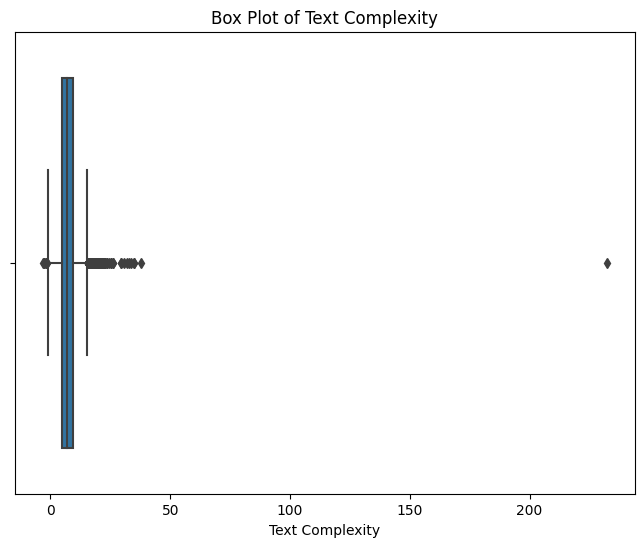

In [27]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_reduced, x='text_complexity')
plt.title("Box Plot of Text Complexity")
plt.xlabel("Text Complexity")
plt.show()

In [31]:
text_complexity_outliers_count = df_reduced[df_reduced['text_complexity'] > 35].value_counts().sum()
text_complexity_outliers_count

2

In [37]:
percentage = 100*text_complexity_outliers_count/df_reduced.shape[0]
print(f'Outliers for Text Complexity are removed as they just represent the {percentage:.3f}% of the Dataset')

Outliers for Text Complexity are removed as they just represent the 0.013% of the Dataset


In [38]:
df_reduced.shape

(15738, 5)

In [39]:
df_reduced = df_reduced[df_reduced['text_complexity'] <= 35]
df_reduced.shape

(15736, 5)

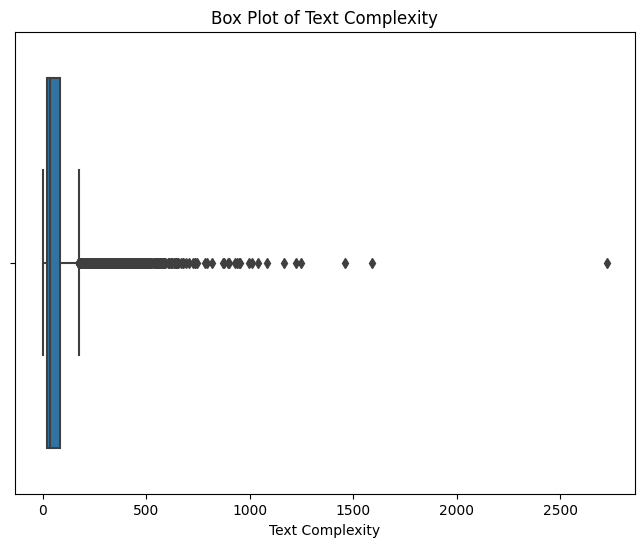

In [40]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_reduced, x='word_count')
plt.title("Box Plot of Text Complexity")
plt.xlabel("Text Complexity")
plt.show()

In [41]:
df_reduced['word_count'].describe().T

count    15736.000000
mean        67.462697
std         89.429364
min          1.000000
25%         18.000000
50%         37.000000
75%         81.000000
max       2725.000000
Name: word_count, dtype: float64

In [45]:
df_reduced[df_reduced['word_count'] > 1500].value_counts().sum()

2

In [46]:
text_word_count_outliers_count = df_reduced[df_reduced['word_count'] > 1500].value_counts().sum()
text_word_count_outliers_count

2

In [47]:
percentage = 100*text_word_count_outliers_count/df_reduced.shape[0]
print(f'Outliers for Word Count are removed as they just represent the {percentage:.3f}% of the Dataset')

Outliers for Word Count are removed as they just represent the 0.013% of the Dataset


In [48]:
df_reduced.shape

(15736, 5)

In [49]:
df_reduced = df_reduced[df_reduced['word_count'] <= 1500]
df_reduced.shape

(15734, 5)

# Dataset Saving

In [50]:
df_reduced.to_csv('../data/processed/df_reduced_with_sentiment.csv')